# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [3]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


[2018-01-22 23:10:02,350] Making new env: CartPole-v1


Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [5]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [6]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [7]:
Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [9]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory


In [11]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [12]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        task.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state
        

## Training

Below we'll train our agent.

In [13]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 4.0 Training loss: 1.0737 Explore P: 0.9996
Episode: 2 Total reward: 16.0 Training loss: 1.0492 Explore P: 0.9980
Episode: 3 Total reward: 24.0 Training loss: 1.0656 Explore P: 0.9957
Episode: 4 Total reward: 9.0 Training loss: 1.0049 Explore P: 0.9948
Episode: 5 Total reward: 16.0 Training loss: 1.0422 Explore P: 0.9932
Episode: 6 Total reward: 38.0 Training loss: 1.0223 Explore P: 0.9895
Episode: 7 Total reward: 19.0 Training loss: 1.0378 Explore P: 0.9876
Episode: 8 Total reward: 21.0 Training loss: 0.9727 Explore P: 0.9856
Episode: 9 Total reward: 16.0 Training loss: 0.9727 Explore P: 0.9840
Episode: 10 Total reward: 16.0 Training loss: 0.9826 Explore P: 0.9824
Episode: 11 Total reward: 22.0 Training loss: 1.0448 Explore P: 0.9803
Episode: 12 Total reward: 16.0 Training loss: 1.0716 Explore P: 0.9787
Episode: 13 Total reward: 25.0 Training loss: 1.1814 Explore P: 0.9763
Episode: 14 Total reward: 16.0 Training loss: 0.8726 Explore P: 0.9748
Episode: 15 Total

Episode: 116 Total reward: 13.0 Training loss: 5.4638 Explore P: 0.7998
Episode: 117 Total reward: 15.0 Training loss: 40.4855 Explore P: 0.7986
Episode: 118 Total reward: 13.0 Training loss: 113.2935 Explore P: 0.7976
Episode: 119 Total reward: 25.0 Training loss: 6.3388 Explore P: 0.7956
Episode: 120 Total reward: 15.0 Training loss: 162.2796 Explore P: 0.7945
Episode: 121 Total reward: 13.0 Training loss: 8.3522 Explore P: 0.7934
Episode: 122 Total reward: 11.0 Training loss: 5.7812 Explore P: 0.7926
Episode: 123 Total reward: 13.0 Training loss: 6.5727 Explore P: 0.7916
Episode: 124 Total reward: 11.0 Training loss: 160.5533 Explore P: 0.7907
Episode: 125 Total reward: 12.0 Training loss: 6.5192 Explore P: 0.7898
Episode: 126 Total reward: 15.0 Training loss: 5.4811 Explore P: 0.7886
Episode: 127 Total reward: 28.0 Training loss: 49.3908 Explore P: 0.7864
Episode: 128 Total reward: 20.0 Training loss: 4.5180 Explore P: 0.7849
Episode: 129 Total reward: 21.0 Training loss: 70.3788 E

Episode: 229 Total reward: 17.0 Training loss: 41.8317 Explore P: 0.6663
Episode: 230 Total reward: 10.0 Training loss: 1.6561 Explore P: 0.6656
Episode: 231 Total reward: 13.0 Training loss: 1.8056 Explore P: 0.6648
Episode: 232 Total reward: 26.0 Training loss: 12.7226 Explore P: 0.6631
Episode: 233 Total reward: 10.0 Training loss: 32.0353 Explore P: 0.6624
Episode: 234 Total reward: 14.0 Training loss: 39.4929 Explore P: 0.6615
Episode: 235 Total reward: 11.0 Training loss: 1.1285 Explore P: 0.6608
Episode: 236 Total reward: 16.0 Training loss: 57.8768 Explore P: 0.6598
Episode: 237 Total reward: 14.0 Training loss: 1.5493 Explore P: 0.6589
Episode: 238 Total reward: 14.0 Training loss: 0.7969 Explore P: 0.6579
Episode: 239 Total reward: 15.0 Training loss: 1.1056 Explore P: 0.6570
Episode: 240 Total reward: 12.0 Training loss: 1.3312 Explore P: 0.6562
Episode: 241 Total reward: 25.0 Training loss: 29.2556 Explore P: 0.6546
Episode: 242 Total reward: 12.0 Training loss: 30.8364 Exp

Episode: 342 Total reward: 130.0 Training loss: 2.4131 Explore P: 0.4382
Episode: 343 Total reward: 99.0 Training loss: 44.5378 Explore P: 0.4339
Episode: 344 Total reward: 76.0 Training loss: 1.7506 Explore P: 0.4307
Episode: 345 Total reward: 48.0 Training loss: 2.4862 Explore P: 0.4287
Episode: 346 Total reward: 157.0 Training loss: 96.0220 Explore P: 0.4222
Episode: 347 Total reward: 53.0 Training loss: 104.0271 Explore P: 0.4200
Episode: 348 Total reward: 105.0 Training loss: 35.4613 Explore P: 0.4157
Episode: 349 Total reward: 93.0 Training loss: 63.2824 Explore P: 0.4120
Episode: 350 Total reward: 70.0 Training loss: 3.0188 Explore P: 0.4092
Episode: 351 Total reward: 84.0 Training loss: 2.8885 Explore P: 0.4058
Episode: 352 Total reward: 97.0 Training loss: 15.7873 Explore P: 0.4020
Episode: 353 Total reward: 46.0 Training loss: 1.9682 Explore P: 0.4002
Episode: 354 Total reward: 27.0 Training loss: 4.0400 Explore P: 0.3992
Episode: 355 Total reward: 112.0 Training loss: 33.653

Episode: 458 Total reward: 19.0 Training loss: 2.0607 Explore P: 0.1871
Episode: 459 Total reward: 86.0 Training loss: 1.1259 Explore P: 0.1856
Episode: 460 Total reward: 71.0 Training loss: 2.0399 Explore P: 0.1843
Episode: 461 Total reward: 99.0 Training loss: 1.6285 Explore P: 0.1826
Episode: 462 Total reward: 115.0 Training loss: 1.0274 Explore P: 0.1806
Episode: 463 Total reward: 152.0 Training loss: 2.1218 Explore P: 0.1781
Episode: 464 Total reward: 84.0 Training loss: 1.4351 Explore P: 0.1767
Episode: 465 Total reward: 56.0 Training loss: 1.3530 Explore P: 0.1757
Episode: 466 Total reward: 109.0 Training loss: 1.5158 Explore P: 0.1739
Episode: 467 Total reward: 98.0 Training loss: 1.5243 Explore P: 0.1723
Episode: 468 Total reward: 56.0 Training loss: 68.6066 Explore P: 0.1714
Episode: 469 Total reward: 44.0 Training loss: 0.8905 Explore P: 0.1707
Episode: 470 Total reward: 90.0 Training loss: 1.1282 Explore P: 0.1693
Episode: 471 Total reward: 76.0 Training loss: 116.9575 Expl

Episode: 576 Total reward: 48.0 Training loss: 0.4838 Explore P: 0.0805
Episode: 577 Total reward: 70.0 Training loss: 0.3011 Explore P: 0.0800
Episode: 578 Total reward: 86.0 Training loss: 0.8479 Explore P: 0.0794
Episode: 579 Total reward: 70.0 Training loss: 0.7450 Explore P: 0.0789
Episode: 580 Total reward: 49.0 Training loss: 2.0026 Explore P: 0.0786
Episode: 581 Total reward: 47.0 Training loss: 0.4008 Explore P: 0.0783
Episode: 582 Total reward: 51.0 Training loss: 0.5786 Explore P: 0.0779
Episode: 583 Total reward: 111.0 Training loss: 1.2987 Explore P: 0.0772
Episode: 584 Total reward: 98.0 Training loss: 0.8246 Explore P: 0.0765
Episode: 585 Total reward: 185.0 Training loss: 2.5645 Explore P: 0.0753
Episode: 586 Total reward: 88.0 Training loss: 0.2319 Explore P: 0.0747
Episode: 587 Total reward: 135.0 Training loss: 0.3139 Explore P: 0.0739
Episode: 588 Total reward: 110.0 Training loss: 0.4503 Explore P: 0.0732
Episode: 589 Total reward: 104.0 Training loss: 0.3013 Explo

Episode: 709 Total reward: 13.0 Training loss: 2.9894 Explore P: 0.0291
Episode: 710 Total reward: 10.0 Training loss: 3.6494 Explore P: 0.0291
Episode: 711 Total reward: 12.0 Training loss: 3.7982 Explore P: 0.0291
Episode: 712 Total reward: 11.0 Training loss: 1.4596 Explore P: 0.0291
Episode: 713 Total reward: 11.0 Training loss: 2.1030 Explore P: 0.0290
Episode: 714 Total reward: 12.0 Training loss: 1.1448 Explore P: 0.0290
Episode: 715 Total reward: 10.0 Training loss: 3.4838 Explore P: 0.0290
Episode: 716 Total reward: 11.0 Training loss: 2.3403 Explore P: 0.0290
Episode: 717 Total reward: 9.0 Training loss: 2.7584 Explore P: 0.0290
Episode: 718 Total reward: 14.0 Training loss: 3.4922 Explore P: 0.0289
Episode: 719 Total reward: 13.0 Training loss: 3.2720 Explore P: 0.0289
Episode: 720 Total reward: 11.0 Training loss: 2.6274 Explore P: 0.0289
Episode: 721 Total reward: 13.0 Training loss: 3.0718 Explore P: 0.0289
Episode: 722 Total reward: 13.0 Training loss: 2.4204 Explore P: 

Episode: 831 Total reward: 10.0 Training loss: 16.8780 Explore P: 0.0241
Episode: 832 Total reward: 8.0 Training loss: 20.4485 Explore P: 0.0241
Episode: 833 Total reward: 8.0 Training loss: 22.1880 Explore P: 0.0241
Episode: 834 Total reward: 8.0 Training loss: 793.1963 Explore P: 0.0241
Episode: 835 Total reward: 12.0 Training loss: 20.0760 Explore P: 0.0241
Episode: 836 Total reward: 9.0 Training loss: 696.5646 Explore P: 0.0241
Episode: 837 Total reward: 10.0 Training loss: 23.4785 Explore P: 0.0241
Episode: 838 Total reward: 11.0 Training loss: 26.4535 Explore P: 0.0240
Episode: 839 Total reward: 11.0 Training loss: 35.3526 Explore P: 0.0240
Episode: 840 Total reward: 8.0 Training loss: 15.3971 Explore P: 0.0240
Episode: 841 Total reward: 12.0 Training loss: 21.9308 Explore P: 0.0240
Episode: 842 Total reward: 10.0 Training loss: 1244.3374 Explore P: 0.0240
Episode: 843 Total reward: 11.0 Training loss: 24.4130 Explore P: 0.0240
Episode: 844 Total reward: 10.0 Training loss: 51.20

Episode: 947 Total reward: 12.0 Training loss: 23.0244 Explore P: 0.0217
Episode: 948 Total reward: 13.0 Training loss: 12.8878 Explore P: 0.0217
Episode: 949 Total reward: 9.0 Training loss: 28.8594 Explore P: 0.0217
Episode: 950 Total reward: 13.0 Training loss: 1020.1603 Explore P: 0.0217
Episode: 951 Total reward: 14.0 Training loss: 20.8212 Explore P: 0.0217
Episode: 952 Total reward: 13.0 Training loss: 21.9798 Explore P: 0.0217
Episode: 953 Total reward: 12.0 Training loss: 569.4740 Explore P: 0.0216
Episode: 954 Total reward: 14.0 Training loss: 411.3978 Explore P: 0.0216
Episode: 955 Total reward: 11.0 Training loss: 13.7779 Explore P: 0.0216
Episode: 956 Total reward: 14.0 Training loss: 496.9505 Explore P: 0.0216
Episode: 957 Total reward: 11.0 Training loss: 18.5630 Explore P: 0.0216
Episode: 958 Total reward: 13.0 Training loss: 9.2646 Explore P: 0.0216
Episode: 959 Total reward: 11.0 Training loss: 14.3212 Explore P: 0.0216
Episode: 960 Total reward: 16.0 Training loss: 2

In [ ]:
Episode: 1 Total reward: 13.0 Training loss: 1.0202 Explore P: 0.9987
Episode: 2 Total reward: 13.0 Training loss: 1.0752 Explore P: 0.9974
Episode: 3 Total reward: 9.0 Training loss: 1.0600 Explore P: 0.9965
Episode: 4 Total reward: 17.0 Training loss: 1.0429 Explore P: 0.9949
Episode: 5 Total reward: 16.0 Training loss: 1.0519 Explore P: 0.9933
Episode: 6 Total reward: 15.0 Training loss: 1.0574 Explore P: 0.9918
Episode: 7 Total reward: 12.0 Training loss: 1.0889 Explore P: 0.9906
Episode: 8 Total reward: 27.0 Training loss: 1.0859 Explore P: 0.9880
Episode: 9 Total reward: 24.0 Training loss: 1.2007 Explore P: 0.9857
Episode: 10 Total reward: 17.0 Training loss: 1.1116 Explore P: 0.9840
Episode: 11 Total reward: 12.0 Training loss: 1.0739 Explore P: 0.9828
Episode: 12 Total reward: 25.0 Training loss: 1.0805 Explore P: 0.9804
Episode: 13 Total reward: 23.0 Training loss: 1.0628 Explore P: 0.9782
Episode: 14 Total reward: 31.0 Training loss: 1.0248 Explore P: 0.9752
Episode: 15 Total reward: 15.0 Training loss: 0.9859 Explore P: 0.9737
Episode: 16 Total reward: 12.0 Training loss: 1.0983 Explore P: 0.9726
Episode: 17 Total reward: 16.0 Training loss: 1.4343 Explore P: 0.9710
Episode: 18 Total reward: 21.0 Training loss: 1.2696 Explore P: 0.9690
Episode: 19 Total reward: 15.0 Training loss: 1.3542 Explore P: 0.9676
Episode: 20 Total reward: 15.0 Training loss: 1.2635 Explore P: 0.9661
Episode: 21 Total reward: 16.0 Training loss: 1.3648 Explore P: 0.9646
Episode: 22 Total reward: 43.0 Training loss: 1.6088 Explore P: 0.9605
Episode: 23 Total reward: 7.0 Training loss: 1.5027 Explore P: 0.9599
Episode: 24 Total reward: 13.0 Training loss: 1.7275 Explore P: 0.9586
Episode: 25 Total reward: 18.0 Training loss: 1.3902 Explore P: 0.9569
Episode: 26 Total reward: 27.0 Training loss: 2.5874 Explore P: 0.9544
Episode: 27 Total reward: 32.0 Training loss: 1.5907 Explore P: 0.9513
Episode: 28 Total reward: 17.0 Training loss: 2.1144 Explore P: 0.9497
Episode: 29 Total reward: 34.0 Training loss: 1.7340 Explore P: 0.9466
Episode: 30 Total reward: 18.0 Training loss: 2.5100 Explore P: 0.9449
Episode: 31 Total reward: 15.0 Training loss: 2.0166 Explore P: 0.9435
Episode: 32 Total reward: 11.0 Training loss: 1.8675 Explore P: 0.9424
Episode: 33 Total reward: 18.0 Training loss: 4.0481 Explore P: 0.9408
Episode: 34 Total reward: 10.0 Training loss: 4.0895 Explore P: 0.9398
Episode: 35 Total reward: 15.0 Training loss: 2.1252 Explore P: 0.9384
Episode: 36 Total reward: 14.0 Training loss: 4.7765 Explore P: 0.9371
Episode: 37 Total reward: 16.0 Training loss: 3.3848 Explore P: 0.9357
Episode: 38 Total reward: 21.0 Training loss: 3.9125 Explore P: 0.9337
Episode: 39 Total reward: 16.0 Training loss: 2.6183 Explore P: 0.9322
Episode: 40 Total reward: 20.0 Training loss: 5.4929 Explore P: 0.9304
Episode: 41 Total reward: 18.0 Training loss: 3.6606 Explore P: 0.9287
Episode: 42 Total reward: 17.0 Training loss: 4.5812 Explore P: 0.9272
Episode: 43 Total reward: 10.0 Training loss: 3.7633 Explore P: 0.9263
Episode: 44 Total reward: 8.0 Training loss: 4.6176 Explore P: 0.9255
Episode: 45 Total reward: 39.0 Training loss: 4.2732 Explore P: 0.9220
Episode: 46 Total reward: 18.0 Training loss: 4.0041 Explore P: 0.9203
Episode: 47 Total reward: 11.0 Training loss: 4.4035 Explore P: 0.9193
Episode: 48 Total reward: 25.0 Training loss: 5.4287 Explore P: 0.9171
Episode: 49 Total reward: 19.0 Training loss: 9.6972 Explore P: 0.9153
Episode: 50 Total reward: 11.0 Training loss: 16.3460 Explore P: 0.9143
Episode: 51 Total reward: 11.0 Training loss: 13.4854 Explore P: 0.9133
Episode: 52 Total reward: 12.0 Training loss: 12.8016 Explore P: 0.9123
Episode: 53 Total reward: 13.0 Training loss: 5.8589 Explore P: 0.9111
Episode: 54 Total reward: 12.0 Training loss: 8.5924 Explore P: 0.9100
Episode: 55 Total reward: 19.0 Training loss: 8.6204 Explore P: 0.9083
Episode: 56 Total reward: 36.0 Training loss: 14.2701 Explore P: 0.9051
Episode: 57 Total reward: 9.0 Training loss: 4.5481 Explore P: 0.9043
Episode: 58 Total reward: 22.0 Training loss: 12.9695 Explore P: 0.9023
Episode: 59 Total reward: 36.0 Training loss: 11.2639 Explore P: 0.8991
Episode: 60 Total reward: 16.0 Training loss: 7.7648 Explore P: 0.8977
Episode: 61 Total reward: 31.0 Training loss: 4.6997 Explore P: 0.8949
Episode: 62 Total reward: 13.0 Training loss: 5.9755 Explore P: 0.8938
Episode: 63 Total reward: 10.0 Training loss: 39.1040 Explore P: 0.8929
Episode: 64 Total reward: 14.0 Training loss: 23.2767 Explore P: 0.8917
Episode: 65 Total reward: 12.0 Training loss: 9.3477 Explore P: 0.8906
Episode: 66 Total reward: 20.0 Training loss: 6.4336 Explore P: 0.8888
Episode: 67 Total reward: 29.0 Training loss: 17.1522 Explore P: 0.8863
Episode: 68 Total reward: 13.0 Training loss: 39.3250 Explore P: 0.8852
Episode: 69 Total reward: 20.0 Training loss: 6.2099 Explore P: 0.8834
Episode: 70 Total reward: 15.0 Training loss: 20.9229 Explore P: 0.8821
Episode: 71 Total reward: 27.0 Training loss: 24.7817 Explore P: 0.8797
Episode: 72 Total reward: 12.0 Training loss: 20.7842 Explore P: 0.8787
Episode: 73 Total reward: 15.0 Training loss: 12.3202 Explore P: 0.8774
Episode: 74 Total reward: 31.0 Training loss: 9.2270 Explore P: 0.8747
Episode: 75 Total reward: 13.0 Training loss: 19.8264 Explore P: 0.8736
Episode: 76 Total reward: 20.0 Training loss: 72.9411 Explore P: 0.8719
Episode: 77 Total reward: 27.0 Training loss: 5.2214 Explore P: 0.8695
Episode: 78 Total reward: 14.0 Training loss: 39.3913 Explore P: 0.8683
Episode: 79 Total reward: 16.0 Training loss: 7.9491 Explore P: 0.8670
Episode: 80 Total reward: 18.0 Training loss: 10.8364 Explore P: 0.8654
Episode: 81 Total reward: 16.0 Training loss: 22.2031 Explore P: 0.8641
Episode: 82 Total reward: 21.0 Training loss: 23.6590 Explore P: 0.8623
Episode: 83 Total reward: 13.0 Training loss: 8.4819 Explore P: 0.8612
Episode: 84 Total reward: 10.0 Training loss: 13.3548 Explore P: 0.8603
Episode: 85 Total reward: 13.0 Training loss: 18.0272 Explore P: 0.8592
Episode: 86 Total reward: 24.0 Training loss: 42.1243 Explore P: 0.8572
Episode: 87 Total reward: 9.0 Training loss: 30.8526 Explore P: 0.8564
Episode: 88 Total reward: 22.0 Training loss: 36.6084 Explore P: 0.8546
Episode: 89 Total reward: 7.0 Training loss: 10.5430 Explore P: 0.8540
Episode: 90 Total reward: 12.0 Training loss: 25.5808 Explore P: 0.8529
Episode: 91 Total reward: 17.0 Training loss: 47.3073 Explore P: 0.8515
Episode: 92 Total reward: 21.0 Training loss: 7.9998 Explore P: 0.8498
Episode: 93 Total reward: 15.0 Training loss: 66.6464 Explore P: 0.8485
Episode: 94 Total reward: 17.0 Training loss: 95.6354 Explore P: 0.8471
Episode: 95 Total reward: 23.0 Training loss: 57.4714 Explore P: 0.8451
Episode: 96 Total reward: 11.0 Training loss: 40.7717 Explore P: 0.8442
Episode: 97 Total reward: 13.0 Training loss: 43.3380 Explore P: 0.8431
Episode: 98 Total reward: 9.0 Training loss: 10.8368 Explore P: 0.8424
Episode: 99 Total reward: 21.0 Training loss: 57.7325 Explore P: 0.8406
Episode: 100 Total reward: 11.0 Training loss: 9.7291 Explore P: 0.8397
Episode: 101 Total reward: 10.0 Training loss: 10.4052 Explore P: 0.8389
Episode: 102 Total reward: 26.0 Training loss: 60.4829 Explore P: 0.8368
Episode: 103 Total reward: 34.0 Training loss: 9.0924 Explore P: 0.8339
Episode: 104 Total reward: 30.0 Training loss: 178.0664 Explore P: 0.8315
Episode: 105 Total reward: 14.0 Training loss: 9.0423 Explore P: 0.8303
Episode: 106 Total reward: 18.0 Training loss: 126.9380 Explore P: 0.8289
Episode: 107 Total reward: 11.0 Training loss: 58.9921 Explore P: 0.8280
Episode: 108 Total reward: 20.0 Training loss: 9.1945 Explore P: 0.8263
Episode: 109 Total reward: 9.0 Training loss: 9.2887 Explore P: 0.8256
Episode: 110 Total reward: 29.0 Training loss: 20.7970 Explore P: 0.8232
Episode: 111 Total reward: 17.0 Training loss: 144.6258 Explore P: 0.8218
Episode: 112 Total reward: 15.0 Training loss: 82.4089 Explore P: 0.8206
Episode: 113 Total reward: 15.0 Training loss: 39.9963 Explore P: 0.8194
Episode: 114 Total reward: 8.0 Training loss: 9.8394 Explore P: 0.8188
Episode: 115 Total reward: 29.0 Training loss: 76.9930 Explore P: 0.8164
Episode: 116 Total reward: 21.0 Training loss: 25.0172 Explore P: 0.8147
Episode: 117 Total reward: 24.0 Training loss: 143.5481 Explore P: 0.8128
Episode: 118 Total reward: 35.0 Training loss: 86.5429 Explore P: 0.8100
Episode: 119 Total reward: 28.0 Training loss: 8.4315 Explore P: 0.8078
Episode: 120 Total reward: 13.0 Training loss: 25.7062 Explore P: 0.8067
Episode: 121 Total reward: 9.0 Training loss: 6.5005 Explore P: 0.8060
Episode: 122 Total reward: 32.0 Training loss: 90.7984 Explore P: 0.8035
Episode: 123 Total reward: 21.0 Training loss: 130.2779 Explore P: 0.8018
Episode: 124 Total reward: 15.0 Training loss: 167.6294 Explore P: 0.8006
Episode: 125 Total reward: 15.0 Training loss: 74.7611 Explore P: 0.7994
Episode: 126 Total reward: 20.0 Training loss: 119.3178 Explore P: 0.7978
Episode: 127 Total reward: 18.0 Training loss: 196.5175 Explore P: 0.7964
Episode: 128 Total reward: 8.0 Training loss: 45.2131 Explore P: 0.7958
Episode: 129 Total reward: 24.0 Training loss: 86.0374 Explore P: 0.7939
Episode: 130 Total reward: 11.0 Training loss: 7.8129 Explore P: 0.7931
Episode: 131 Total reward: 11.0 Training loss: 76.8442 Explore P: 0.7922
Episode: 132 Total reward: 28.0 Training loss: 196.6863 Explore P: 0.7900
Episode: 133 Total reward: 9.0 Training loss: 45.7586 Explore P: 0.7893
Episode: 134 Total reward: 21.0 Training loss: 5.8484 Explore P: 0.7877
Episode: 135 Total reward: 10.0 Training loss: 7.3919 Explore P: 0.7869
Episode: 136 Total reward: 17.0 Training loss: 12.3142 Explore P: 0.7856
Episode: 137 Total reward: 16.0 Training loss: 75.7170 Explore P: 0.7843
Episode: 138 Total reward: 12.0 Training loss: 145.3568 Explore P: 0.7834
Episode: 139 Total reward: 27.0 Training loss: 121.1114 Explore P: 0.7813
Episode: 140 Total reward: 26.0 Training loss: 7.3243 Explore P: 0.7793
Episode: 141 Total reward: 40.0 Training loss: 10.6523 Explore P: 0.7762
Episode: 142 Total reward: 14.0 Training loss: 6.9482 Explore P: 0.7752
Episode: 143 Total reward: 24.0 Training loss: 137.7784 Explore P: 0.7733
Episode: 144 Total reward: 12.0 Training loss: 98.8381 Explore P: 0.7724
Episode: 145 Total reward: 8.0 Training loss: 14.1739 Explore P: 0.7718
Episode: 146 Total reward: 51.0 Training loss: 69.1545 Explore P: 0.7679
Episode: 147 Total reward: 29.0 Training loss: 249.9989 Explore P: 0.7657
Episode: 148 Total reward: 9.0 Training loss: 140.8663 Explore P: 0.7651
Episode: 149 Total reward: 13.0 Training loss: 141.5930 Explore P: 0.7641
Episode: 150 Total reward: 19.0 Training loss: 12.6228 Explore P: 0.7627
Episode: 151 Total reward: 19.0 Training loss: 136.3315 Explore P: 0.7612
Episode: 152 Total reward: 10.0 Training loss: 110.3699 Explore P: 0.7605
Episode: 153 Total reward: 18.0 Training loss: 8.3900 Explore P: 0.7591
Episode: 154 Total reward: 18.0 Training loss: 96.3717 Explore P: 0.7578
Episode: 155 Total reward: 7.0 Training loss: 6.0889 Explore P: 0.7573
Episode: 156 Total reward: 15.0 Training loss: 126.7419 Explore P: 0.7561
Episode: 157 Total reward: 15.0 Training loss: 67.2544 Explore P: 0.7550
Episode: 158 Total reward: 26.0 Training loss: 12.2839 Explore P: 0.7531
Episode: 159 Total reward: 20.0 Training loss: 5.8118 Explore P: 0.7516
Episode: 160 Total reward: 10.0 Training loss: 96.4570 Explore P: 0.7509
Episode: 161 Total reward: 23.0 Training loss: 7.6207 Explore P: 0.7492
Episode: 162 Total reward: 18.0 Training loss: 66.5249 Explore P: 0.7478
Episode: 163 Total reward: 18.0 Training loss: 111.3273 Explore P: 0.7465
Episode: 164 Total reward: 21.0 Training loss: 11.5292 Explore P: 0.7450
Episode: 165 Total reward: 17.0 Training loss: 6.3130 Explore P: 0.7437
Episode: 166 Total reward: 22.0 Training loss: 153.8167 Explore P: 0.7421
Episode: 167 Total reward: 17.0 Training loss: 7.0915 Explore P: 0.7408
Episode: 168 Total reward: 34.0 Training loss: 228.3831 Explore P: 0.7384
Episode: 169 Total reward: 13.0 Training loss: 8.5996 Explore P: 0.7374
Episode: 170 Total reward: 13.0 Training loss: 90.8898 Explore P: 0.7365
Episode: 171 Total reward: 20.0 Training loss: 4.8179 Explore P: 0.7350
Episode: 172 Total reward: 9.0 Training loss: 6.2508 Explore P: 0.7344
Episode: 173 Total reward: 14.0 Training loss: 5.2401 Explore P: 0.7334
Episode: 174 Total reward: 12.0 Training loss: 3.9268 Explore P: 0.7325
Episode: 175 Total reward: 12.0 Training loss: 5.6376 Explore P: 0.7316
Episode: 176 Total reward: 11.0 Training loss: 44.5308 Explore P: 0.7308
Episode: 177 Total reward: 12.0 Training loss: 4.9717 Explore P: 0.7300
Episode: 178 Total reward: 9.0 Training loss: 181.0085 Explore P: 0.7293
Episode: 179 Total reward: 11.0 Training loss: 73.1134 Explore P: 0.7285
Episode: 180 Total reward: 13.0 Training loss: 87.3085 Explore P: 0.7276
Episode: 181 Total reward: 12.0 Training loss: 121.6627 Explore P: 0.7267
Episode: 182 Total reward: 12.0 Training loss: 58.1967 Explore P: 0.7259
Episode: 183 Total reward: 13.0 Training loss: 85.1540 Explore P: 0.7249
Episode: 184 Total reward: 16.0 Training loss: 5.1214 Explore P: 0.7238
Episode: 185 Total reward: 19.0 Training loss: 69.1839 Explore P: 0.7224
Episode: 186 Total reward: 7.0 Training loss: 63.2256 Explore P: 0.7219
Episode: 187 Total reward: 17.0 Training loss: 73.2788 Explore P: 0.7207
Episode: 188 Total reward: 15.0 Training loss: 78.6213 Explore P: 0.7197
Episode: 189 Total reward: 11.0 Training loss: 88.5211 Explore P: 0.7189
Episode: 190 Total reward: 14.0 Training loss: 60.1332 Explore P: 0.7179
Episode: 191 Total reward: 15.0 Training loss: 135.7724 Explore P: 0.7168
Episode: 192 Total reward: 15.0 Training loss: 156.9691 Explore P: 0.7158
Episode: 193 Total reward: 17.0 Training loss: 93.3756 Explore P: 0.7146
Episode: 194 Total reward: 12.0 Training loss: 3.0462 Explore P: 0.7137
Episode: 195 Total reward: 9.0 Training loss: 119.2650 Explore P: 0.7131
Episode: 196 Total reward: 13.0 Training loss: 66.6383 Explore P: 0.7122
Episode: 197 Total reward: 9.0 Training loss: 113.7849 Explore P: 0.7116
Episode: 198 Total reward: 13.0 Training loss: 54.6072 Explore P: 0.7106
Episode: 199 Total reward: 19.0 Training loss: 54.8980 Explore P: 0.7093
Episode: 200 Total reward: 20.0 Training loss: 155.5480 Explore P: 0.7079
Episode: 201 Total reward: 10.0 Training loss: 45.8685 Explore P: 0.7072
Episode: 202 Total reward: 14.0 Training loss: 53.5145 Explore P: 0.7062
Episode: 203 Total reward: 8.0 Training loss: 107.9623 Explore P: 0.7057
Episode: 204 Total reward: 21.0 Training loss: 40.2749 Explore P: 0.7042
Episode: 205 Total reward: 32.0 Training loss: 43.2627 Explore P: 0.7020
Episode: 206 Total reward: 9.0 Training loss: 55.5398 Explore P: 0.7014
Episode: 207 Total reward: 15.0 Training loss: 1.9959 Explore P: 0.7004
Episode: 208 Total reward: 12.0 Training loss: 105.3751 Explore P: 0.6995
Episode: 209 Total reward: 11.0 Training loss: 40.8319 Explore P: 0.6988
Episode: 210 Total reward: 10.0 Training loss: 89.7147 Explore P: 0.6981
Episode: 211 Total reward: 10.0 Training loss: 1.1946 Explore P: 0.6974
Episode: 212 Total reward: 10.0 Training loss: 80.6916 Explore P: 0.6967
Episode: 213 Total reward: 24.0 Training loss: 88.0977 Explore P: 0.6951
Episode: 214 Total reward: 14.0 Training loss: 46.4105 Explore P: 0.6941
Episode: 215 Total reward: 11.0 Training loss: 40.3726 Explore P: 0.6933
Episode: 216 Total reward: 11.0 Training loss: 3.0770 Explore P: 0.6926
Episode: 217 Total reward: 8.0 Training loss: 1.7495 Explore P: 0.6921
Episode: 218 Total reward: 16.0 Training loss: 1.5615 Explore P: 0.6910
Episode: 219 Total reward: 17.0 Training loss: 2.0250 Explore P: 0.6898
Episode: 220 Total reward: 18.0 Training loss: 37.8432 Explore P: 0.6886
Episode: 221 Total reward: 17.0 Training loss: 1.9049 Explore P: 0.6874
Episode: 222 Total reward: 16.0 Training loss: 1.9652 Explore P: 0.6863
Episode: 223 Total reward: 16.0 Training loss: 1.4384 Explore P: 0.6853
Episode: 224 Total reward: 27.0 Training loss: 66.0615 Explore P: 0.6834
Episode: 225 Total reward: 9.0 Training loss: 0.8478 Explore P: 0.6828
Episode: 226 Total reward: 14.0 Training loss: 1.0319 Explore P: 0.6819
Episode: 227 Total reward: 17.0 Training loss: 97.6957 Explore P: 0.6808
Episode: 228 Total reward: 8.0 Training loss: 68.0521 Explore P: 0.6802
Episode: 229 Total reward: 9.0 Training loss: 110.8437 Explore P: 0.6796
Episode: 230 Total reward: 19.0 Training loss: 1.6856 Explore P: 0.6783
Episode: 231 Total reward: 9.0 Training loss: 2.0634 Explore P: 0.6777
Episode: 232 Total reward: 11.0 Training loss: 32.0714 Explore P: 0.6770
Episode: 233 Total reward: 9.0 Training loss: 2.0387 Explore P: 0.6764
Episode: 234 Total reward: 13.0 Training loss: 66.9349 Explore P: 0.6755
Episode: 235 Total reward: 14.0 Training loss: 110.6725 Explore P: 0.6746
Episode: 236 Total reward: 18.0 Training loss: 1.0585 Explore P: 0.6734
Episode: 237 Total reward: 11.0 Training loss: 117.0101 Explore P: 0.6727
Episode: 238 Total reward: 7.0 Training loss: 2.6115 Explore P: 0.6722
Episode: 239 Total reward: 10.0 Training loss: 124.7320 Explore P: 0.6716
Episode: 240 Total reward: 18.0 Training loss: 2.5475 Explore P: 0.6704
Episode: 241 Total reward: 37.0 Training loss: 2.1454 Explore P: 0.6679
Episode: 242 Total reward: 11.0 Training loss: 23.6042 Explore P: 0.6672
Episode: 243 Total reward: 32.0 Training loss: 1.4344 Explore P: 0.6651
Episode: 244 Total reward: 9.0 Training loss: 1.5328 Explore P: 0.6645
Episode: 245 Total reward: 14.0 Training loss: 84.7870 Explore P: 0.6636
Episode: 246 Total reward: 12.0 Training loss: 2.7292 Explore P: 0.6628
Episode: 247 Total reward: 26.0 Training loss: 40.6692 Explore P: 0.6611
Episode: 248 Total reward: 12.0 Training loss: 22.0901 Explore P: 0.6603
Episode: 249 Total reward: 15.0 Training loss: 37.9304 Explore P: 0.6594
Episode: 250 Total reward: 20.0 Training loss: 1.4137 Explore P: 0.6581
Episode: 251 Total reward: 16.0 Training loss: 1.7831 Explore P: 0.6570
Episode: 252 Total reward: 9.0 Training loss: 38.0640 Explore P: 0.6565
Episode: 253 Total reward: 17.0 Training loss: 21.7703 Explore P: 0.6554
Episode: 254 Total reward: 24.0 Training loss: 40.3204 Explore P: 0.6538
Episode: 255 Total reward: 30.0 Training loss: 43.4179 Explore P: 0.6519
Episode: 256 Total reward: 11.0 Training loss: 60.9330 Explore P: 0.6512
Episode: 257 Total reward: 14.0 Training loss: 66.6886 Explore P: 0.6503
Episode: 258 Total reward: 15.0 Training loss: 2.5639 Explore P: 0.6493
Episode: 259 Total reward: 19.0 Training loss: 2.6969 Explore P: 0.6481
Episode: 260 Total reward: 10.0 Training loss: 2.6837 Explore P: 0.6475
Episode: 261 Total reward: 30.0 Training loss: 20.6603 Explore P: 0.6456
Episode: 262 Total reward: 17.0 Training loss: 32.1585 Explore P: 0.6445
Episode: 263 Total reward: 15.0 Training loss: 1.0833 Explore P: 0.6435
Episode: 264 Total reward: 13.0 Training loss: 81.4551 Explore P: 0.6427
Episode: 265 Total reward: 17.0 Training loss: 3.3823 Explore P: 0.6416
Episode: 266 Total reward: 11.0 Training loss: 36.3942 Explore P: 0.6409
Episode: 267 Total reward: 11.0 Training loss: 1.6628 Explore P: 0.6402
Episode: 268 Total reward: 33.0 Training loss: 26.9925 Explore P: 0.6382
Episode: 269 Total reward: 18.0 Training loss: 45.8608 Explore P: 0.6370
Episode: 270 Total reward: 20.0 Training loss: 2.7911 Explore P: 0.6358
Episode: 271 Total reward: 10.0 Training loss: 35.9215 Explore P: 0.6352
Episode: 272 Total reward: 14.0 Training loss: 2.5923 Explore P: 0.6343
Episode: 273 Total reward: 16.0 Training loss: 41.2339 Explore P: 0.6333
Episode: 274 Total reward: 18.0 Training loss: 46.7318 Explore P: 0.6322
Episode: 275 Total reward: 14.0 Training loss: 2.7245 Explore P: 0.6313
Episode: 276 Total reward: 8.0 Training loss: 16.2681 Explore P: 0.6308
Episode: 277 Total reward: 10.0 Training loss: 21.6856 Explore P: 0.6302
Episode: 278 Total reward: 12.0 Training loss: 1.7879 Explore P: 0.6294
Episode: 279 Total reward: 10.0 Training loss: 97.1567 Explore P: 0.6288
Episode: 280 Total reward: 16.0 Training loss: 3.4710 Explore P: 0.6278
Episode: 281 Total reward: 14.0 Training loss: 65.8457 Explore P: 0.6270
Episode: 282 Total reward: 21.0 Training loss: 32.4442 Explore P: 0.6257
Episode: 283 Total reward: 17.0 Training loss: 48.0136 Explore P: 0.6246
Episode: 284 Total reward: 11.0 Training loss: 2.8833 Explore P: 0.6239
Episode: 285 Total reward: 16.0 Training loss: 92.6062 Explore P: 0.6230
Episode: 286 Total reward: 16.0 Training loss: 19.1051 Explore P: 0.6220
Episode: 287 Total reward: 7.0 Training loss: 1.8220 Explore P: 0.6216
Episode: 288 Total reward: 16.0 Training loss: 41.3844 Explore P: 0.6206
Episode: 289 Total reward: 18.0 Training loss: 50.0580 Explore P: 0.6195
Episode: 290 Total reward: 13.0 Training loss: 83.2142 Explore P: 0.6187
Episode: 291 Total reward: 14.0 Training loss: 70.2605 Explore P: 0.6178
Episode: 292 Total reward: 16.0 Training loss: 53.9664 Explore P: 0.6169
Episode: 293 Total reward: 17.0 Training loss: 3.2764 Explore P: 0.6158
Episode: 294 Total reward: 18.0 Training loss: 17.7963 Explore P: 0.6147
Episode: 295 Total reward: 17.0 Training loss: 32.3772 Explore P: 0.6137
Episode: 296 Total reward: 32.0 Training loss: 18.3755 Explore P: 0.6118
Episode: 297 Total reward: 29.0 Training loss: 17.1377 Explore P: 0.6100
Episode: 298 Total reward: 12.0 Training loss: 14.2922 Explore P: 0.6093
Episode: 299 Total reward: 14.0 Training loss: 29.2226 Explore P: 0.6085
Episode: 300 Total reward: 17.0 Training loss: 38.9089 Explore P: 0.6075
Episode: 301 Total reward: 9.0 Training loss: 62.2483 Explore P: 0.6069
Episode: 302 Total reward: 22.0 Training loss: 2.3240 Explore P: 0.6056
Episode: 303 Total reward: 16.0 Training loss: 0.9979 Explore P: 0.6047
Episode: 304 Total reward: 8.0 Training loss: 67.9231 Explore P: 0.6042
Episode: 305 Total reward: 13.0 Training loss: 33.0928 Explore P: 0.6034
Episode: 306 Total reward: 20.0 Training loss: 1.3173 Explore P: 0.6022
Episode: 307 Total reward: 23.0 Training loss: 50.2106 Explore P: 0.6009
Episode: 308 Total reward: 17.0 Training loss: 52.5245 Explore P: 0.5999
Episode: 309 Total reward: 20.0 Training loss: 32.5832 Explore P: 0.5987
Episode: 310 Total reward: 19.0 Training loss: 29.0224 Explore P: 0.5976
Episode: 311 Total reward: 19.0 Training loss: 29.8863 Explore P: 0.5965
Episode: 312 Total reward: 27.0 Training loss: 34.4016 Explore P: 0.5949
Episode: 313 Total reward: 9.0 Training loss: 1.1433 Explore P: 0.5944
Episode: 314 Total reward: 20.0 Training loss: 28.8137 Explore P: 0.5932
Episode: 315 Total reward: 24.0 Training loss: 48.5379 Explore P: 0.5918
Episode: 316 Total reward: 28.0 Training loss: 45.2671 Explore P: 0.5902
Episode: 317 Total reward: 13.0 Training loss: 45.9822 Explore P: 0.5894
Episode: 318 Total reward: 12.0 Training loss: 86.3972 Explore P: 0.5887
Episode: 319 Total reward: 10.0 Training loss: 11.2909 Explore P: 0.5881
Episode: 320 Total reward: 11.0 Training loss: 36.5474 Explore P: 0.5875
Episode: 321 Total reward: 13.0 Training loss: 1.1439 Explore P: 0.5867
Episode: 322 Total reward: 8.0 Training loss: 12.6978 Explore P: 0.5863
Episode: 323 Total reward: 20.0 Training loss: 31.7664 Explore P: 0.5851
Episode: 324 Total reward: 8.0 Training loss: 29.4243 Explore P: 0.5847
Episode: 325 Total reward: 13.0 Training loss: 12.2373 Explore P: 0.5839
Episode: 326 Total reward: 19.0 Training loss: 24.2228 Explore P: 0.5828
Episode: 327 Total reward: 68.0 Training loss: 0.7256 Explore P: 0.5790
Episode: 328 Total reward: 11.0 Training loss: 1.2313 Explore P: 0.5783
Episode: 329 Total reward: 15.0 Training loss: 1.3319 Explore P: 0.5775
Episode: 330 Total reward: 53.0 Training loss: 9.9350 Explore P: 0.5745
Episode: 331 Total reward: 74.0 Training loss: 1.4366 Explore P: 0.5703
Episode: 332 Total reward: 16.0 Training loss: 11.2724 Explore P: 0.5694
Episode: 333 Total reward: 34.0 Training loss: 10.6128 Explore P: 0.5675
Episode: 334 Total reward: 27.0 Training loss: 14.9559 Explore P: 0.5660
Episode: 335 Total reward: 31.0 Training loss: 16.6541 Explore P: 0.5643
Episode: 336 Total reward: 49.0 Training loss: 23.3966 Explore P: 0.5616
Episode: 337 Total reward: 40.0 Training loss: 45.3419 Explore P: 0.5594
Episode: 338 Total reward: 71.0 Training loss: 0.8244 Explore P: 0.5555
Episode: 339 Total reward: 56.0 Training loss: 41.4562 Explore P: 0.5525
Episode: 340 Total reward: 18.0 Training loss: 1.2548 Explore P: 0.5515
Episode: 341 Total reward: 56.0 Training loss: 1.5400 Explore P: 0.5485
Episode: 342 Total reward: 34.0 Training loss: 12.0206 Explore P: 0.5466
Episode: 343 Total reward: 67.0 Training loss: 1.4189 Explore P: 0.5430
Episode: 344 Total reward: 27.0 Training loss: 1.3138 Explore P: 0.5416
Episode: 345 Total reward: 42.0 Training loss: 1.1650 Explore P: 0.5394
Episode: 346 Total reward: 23.0 Training loss: 23.1743 Explore P: 0.5382
Episode: 347 Total reward: 54.0 Training loss: 0.6971 Explore P: 0.5353
Episode: 348 Total reward: 34.0 Training loss: 27.2789 Explore P: 0.5335
Episode: 349 Total reward: 25.0 Training loss: 37.4133 Explore P: 0.5322
Episode: 350 Total reward: 20.0 Training loss: 1.6443 Explore P: 0.5312
Episode: 351 Total reward: 26.0 Training loss: 12.6839 Explore P: 0.5298
Episode: 352 Total reward: 40.0 Training loss: 13.3593 Explore P: 0.5278
Episode: 353 Total reward: 18.0 Training loss: 1.7079 Explore P: 0.5268
Episode: 354 Total reward: 47.0 Training loss: 32.5788 Explore P: 0.5244
Episode: 355 Total reward: 20.0 Training loss: 1.6101 Explore P: 0.5234
Episode: 356 Total reward: 53.0 Training loss: 2.5321 Explore P: 0.5207
Episode: 357 Total reward: 15.0 Training loss: 1.6396 Explore P: 0.5199
Episode: 358 Total reward: 76.0 Training loss: 20.8058 Explore P: 0.5160
Episode: 359 Total reward: 12.0 Training loss: 13.0315 Explore P: 0.5154
Episode: 360 Total reward: 42.0 Training loss: 10.1313 Explore P: 0.5133
Episode: 361 Total reward: 53.0 Training loss: 25.4319 Explore P: 0.5106
Episode: 362 Total reward: 33.0 Training loss: 26.4256 Explore P: 0.5090
Episode: 363 Total reward: 85.0 Training loss: 20.2429 Explore P: 0.5048
Episode: 364 Total reward: 23.0 Training loss: 16.1083 Explore P: 0.5036
Episode: 365 Total reward: 30.0 Training loss: 1.6888 Explore P: 0.5022
Episode: 366 Total reward: 66.0 Training loss: 2.0408 Explore P: 0.4989
Episode: 367 Total reward: 37.0 Training loss: 18.6438 Explore P: 0.4971
Episode: 368 Total reward: 50.0 Training loss: 20.1544 Explore P: 0.4947
Episode: 369 Total reward: 78.0 Training loss: 23.8497 Explore P: 0.4909
Episode: 370 Total reward: 83.0 Training loss: 20.6897 Explore P: 0.4869
Episode: 371 Total reward: 44.0 Training loss: 25.4317 Explore P: 0.4849
Episode: 372 Total reward: 44.0 Training loss: 1.5212 Explore P: 0.4828
Episode: 373 Total reward: 14.0 Training loss: 1.5019 Explore P: 0.4821
Episode: 374 Total reward: 31.0 Training loss: 1.8348 Explore P: 0.4806
Episode: 375 Total reward: 25.0 Training loss: 19.7533 Explore P: 0.4795
Episode: 376 Total reward: 51.0 Training loss: 1.5433 Explore P: 0.4771
Episode: 377 Total reward: 23.0 Training loss: 12.9174 Explore P: 0.4760
Episode: 378 Total reward: 67.0 Training loss: 27.2318 Explore P: 0.4729
Episode: 379 Total reward: 26.0 Training loss: 1.9319 Explore P: 0.4717
Episode: 380 Total reward: 35.0 Training loss: 43.2445 Explore P: 0.4701
Episode: 381 Total reward: 33.0 Training loss: 1.5195 Explore P: 0.4686
Episode: 382 Total reward: 30.0 Training loss: 15.4622 Explore P: 0.4672
Episode: 383 Total reward: 12.0 Training loss: 1.8349 Explore P: 0.4666
Episode: 384 Total reward: 25.0 Training loss: 47.7600 Explore P: 0.4655
Episode: 385 Total reward: 36.0 Training loss: 29.6753 Explore P: 0.4639
Episode: 386 Total reward: 50.0 Training loss: 1.1244 Explore P: 0.4616
Episode: 387 Total reward: 35.0 Training loss: 1.0955 Explore P: 0.4600
Episode: 388 Total reward: 52.0 Training loss: 24.9624 Explore P: 0.4577
Episode: 389 Total reward: 52.0 Training loss: 28.2028 Explore P: 0.4554
Episode: 390 Total reward: 132.0 Training loss: 30.5190 Explore P: 0.4495
Episode: 391 Total reward: 25.0 Training loss: 10.3908 Explore P: 0.4484
Episode: 392 Total reward: 56.0 Training loss: 14.1483 Explore P: 0.4460
Episode: 393 Total reward: 110.0 Training loss: 2.0169 Explore P: 0.4412
Episode: 394 Total reward: 78.0 Training loss: 1.2122 Explore P: 0.4379
Episode: 395 Total reward: 44.0 Training loss: 56.4728 Explore P: 0.4360
Episode: 396 Total reward: 90.0 Training loss: 65.6667 Explore P: 0.4322
Episode: 397 Total reward: 36.0 Training loss: 0.9032 Explore P: 0.4307
Episode: 398 Total reward: 40.0 Training loss: 0.8414 Explore P: 0.4290
Episode: 399 Total reward: 109.0 Training loss: 42.5467 Explore P: 0.4244
Episode: 400 Total reward: 37.0 Training loss: 2.6053 Explore P: 0.4229
Episode: 401 Total reward: 62.0 Training loss: 1.2301 Explore P: 0.4203
Episode: 402 Total reward: 42.0 Training loss: 1.1384 Explore P: 0.4186
Episode: 403 Total reward: 71.0 Training loss: 1.6765 Explore P: 0.4157
Episode: 404 Total reward: 88.0 Training loss: 2.4000 Explore P: 0.4122
Episode: 405 Total reward: 55.0 Training loss: 24.7748 Explore P: 0.4100
Episode: 406 Total reward: 33.0 Training loss: 13.5934 Explore P: 0.4087
Episode: 407 Total reward: 44.0 Training loss: 14.6865 Explore P: 0.4069
Episode: 408 Total reward: 40.0 Training loss: 2.0898 Explore P: 0.4053
Episode: 409 Total reward: 98.0 Training loss: 2.1043 Explore P: 0.4015
Episode: 410 Total reward: 63.0 Training loss: 11.3562 Explore P: 0.3990
Episode: 411 Total reward: 50.0 Training loss: 14.1151 Explore P: 0.3971
Episode: 412 Total reward: 44.0 Training loss: 1.2370 Explore P: 0.3954
Episode: 413 Total reward: 56.0 Training loss: 2.1136 Explore P: 0.3932
Episode: 414 Total reward: 61.0 Training loss: 2.2578 Explore P: 0.3909
Episode: 415 Total reward: 49.0 Training loss: 1.3966 Explore P: 0.3890
Episode: 416 Total reward: 55.0 Training loss: 10.2836 Explore P: 0.3869
Episode: 417 Total reward: 121.0 Training loss: 2.2477 Explore P: 0.3824
Episode: 418 Total reward: 46.0 Training loss: 2.3118 Explore P: 0.3807
Episode: 419 Total reward: 70.0 Training loss: 27.3952 Explore P: 0.3781
Episode: 420 Total reward: 72.0 Training loss: 45.7570 Explore P: 0.3755
Episode: 421 Total reward: 41.0 Training loss: 59.1887 Explore P: 0.3740
Episode: 422 Total reward: 67.0 Training loss: 27.0998 Explore P: 0.3716
Episode: 423 Total reward: 46.0 Training loss: 43.1971 Explore P: 0.3699
Episode: 424 Total reward: 52.0 Training loss: 2.0718 Explore P: 0.3680
Episode: 425 Total reward: 92.0 Training loss: 96.7074 Explore P: 0.3647
Episode: 426 Total reward: 60.0 Training loss: 2.0684 Explore P: 0.3626
Episode: 427 Total reward: 106.0 Training loss: 54.1831 Explore P: 0.3589
Episode: 428 Total reward: 76.0 Training loss: 1.9612 Explore P: 0.3563
Episode: 429 Total reward: 42.0 Training loss: 1.6153 Explore P: 0.3548
Episode: 430 Total reward: 77.0 Training loss: 3.9801 Explore P: 0.3522
Episode: 431 Total reward: 123.0 Training loss: 2.0505 Explore P: 0.3480
Episode: 432 Total reward: 150.0 Training loss: 19.4217 Explore P: 0.3430
Episode: 433 Total reward: 57.0 Training loss: 1.5850 Explore P: 0.3411
Episode: 434 Total reward: 74.0 Training loss: 2.4292 Explore P: 0.3386
Episode: 435 Total reward: 97.0 Training loss: 23.5709 Explore P: 0.3354
Episode: 436 Total reward: 99.0 Training loss: 2.0727 Explore P: 0.3322
Episode: 437 Total reward: 101.0 Training loss: 22.3250 Explore P: 0.3290
Episode: 438 Total reward: 46.0 Training loss: 2.0320 Explore P: 0.3275
Episode: 439 Total reward: 51.0 Training loss: 4.8099 Explore P: 0.3259
Episode: 440 Total reward: 111.0 Training loss: 68.3524 Explore P: 0.3224
Episode: 441 Total reward: 167.0 Training loss: 2.3045 Explore P: 0.3173
Episode: 442 Total reward: 80.0 Training loss: 0.8798 Explore P: 0.3148
Episode: 443 Total reward: 170.0 Training loss: 48.6270 Explore P: 0.3097
Episode: 444 Total reward: 77.0 Training loss: 2.2555 Explore P: 0.3074
Episode: 445 Total reward: 84.0 Training loss: 3.0428 Explore P: 0.3049
Episode: 447 Total reward: 12.0 Training loss: 2.8022 Explore P: 0.2987
Episode: 448 Total reward: 66.0 Training loss: 120.3442 Explore P: 0.2968
Episode: 449 Total reward: 152.0 Training loss: 6.2880 Explore P: 0.2925
Episode: 450 Total reward: 141.0 Training loss: 2.8015 Explore P: 0.2885
Episode: 451 Total reward: 99.0 Training loss: 64.0921 Explore P: 0.2858
Episode: 452 Total reward: 79.0 Training loss: 1.5581 Explore P: 0.2836
Episode: 453 Total reward: 49.0 Training loss: 113.2557 Explore P: 0.2823
Episode: 455 Total reward: 106.0 Training loss: 210.4934 Explore P: 0.2741
Episode: 456 Total reward: 109.0 Training loss: 81.6662 Explore P: 0.2712
Episode: 457 Total reward: 56.0 Training loss: 3.2287 Explore P: 0.2697
Episode: 458 Total reward: 138.0 Training loss: 2.5795 Explore P: 0.2662
Episode: 459 Total reward: 93.0 Training loss: 3.4260 Explore P: 0.2638
Episode: 460 Total reward: 71.0 Training loss: 139.3341 Explore P: 0.2620
Episode: 461 Total reward: 106.0 Training loss: 2.6074 Explore P: 0.2594
Episode: 462 Total reward: 63.0 Training loss: 2.8252 Explore P: 0.2578
Episode: 463 Total reward: 71.0 Training loss: 25.8917 Explore P: 0.2560
Episode: 464 Total reward: 79.0 Training loss: 3.8067 Explore P: 0.2541
Episode: 465 Total reward: 86.0 Training loss: 1.6050 Explore P: 0.2520
Episode: 466 Total reward: 88.0 Training loss: 44.2827 Explore P: 0.2499
Episode: 467 Total reward: 72.0 Training loss: 0.7160 Explore P: 0.2482
Episode: 468 Total reward: 152.0 Training loss: 75.7239 Explore P: 0.2446
Episode: 469 Total reward: 122.0 Training loss: 7.4345 Explore P: 0.2417
Episode: 470 Total reward: 81.0 Training loss: 101.0922 Explore P: 0.2399
Episode: 471 Total reward: 38.0 Training loss: 1.6301 Explore P: 0.2390
Episode: 472 Total reward: 79.0 Training loss: 72.4920 Explore P: 0.2372
Episode: 473 Total reward: 190.0 Training loss: 1.3869 Explore P: 0.2329
Episode: 474 Total reward: 197.0 Training loss: 1.5386 Explore P: 0.2286
Episode: 476 Total reward: 42.0 Training loss: 0.8364 Explore P: 0.2233
Episode: 477 Total reward: 134.0 Training loss: 88.3979 Explore P: 0.2205
Episode: 478 Total reward: 128.0 Training loss: 94.1007 Explore P: 0.2178
Episode: 479 Total reward: 79.0 Training loss: 103.1366 Explore P: 0.2162
Episode: 480 Total reward: 169.0 Training loss: 58.8788 Explore P: 0.2127
Episode: 481 Total reward: 160.0 Training loss: 1.1934 Explore P: 0.2095
Episode: 482 Total reward: 81.0 Training loss: 2.9244 Explore P: 0.2079
Episode: 484 Total reward: 68.0 Training loss: 77.9688 Explore P: 0.2027
Episode: 486 Total reward: 17.0 Training loss: 0.6864 Explore P: 0.1985
Episode: 488 Total reward: 62.0 Training loss: 1.9978 Explore P: 0.1937
Episode: 489 Total reward: 178.0 Training loss: 228.6335 Explore P: 0.1904
Episode: 490 Total reward: 114.0 Training loss: 0.4453 Explore P: 0.1884
Episode: 491 Total reward: 127.0 Training loss: 1.6523 Explore P: 0.1861
Episode: 492 Total reward: 124.0 Training loss: 120.2207 Explore P: 0.1840
Episode: 493 Total reward: 184.0 Training loss: 0.5913 Explore P: 0.1808
Episode: 494 Total reward: 129.0 Training loss: 56.3829 Explore P: 0.1786
Episode: 495 Total reward: 95.0 Training loss: 1.9883 Explore P: 0.1770
Episode: 496 Total reward: 129.0 Training loss: 1.2513 Explore P: 0.1749
Episode: 497 Total reward: 176.0 Training loss: 1.0322 Explore P: 0.1720
Episode: 498 Total reward: 132.0 Training loss: 0.9320 Explore P: 0.1699
Episode: 499 Total reward: 146.0 Training loss: 289.4379 Explore P: 0.1675
Episode: 500 Total reward: 147.0 Training loss: 0.5124 Explore P: 0.1652
Episode: 501 Total reward: 166.0 Training loss: 0.9444 Explore P: 0.1627
Episode: 503 Total reward: 31.0 Training loss: 1.4756 Explore P: 0.1592
Episode: 504 Total reward: 129.0 Training loss: 0.6077 Explore P: 0.1573
Episode: 505 Total reward: 127.0 Training loss: 1.2508 Explore P: 0.1554
Episode: 506 Total reward: 123.0 Training loss: 0.8265 Explore P: 0.1537
Episode: 507 Total reward: 159.0 Training loss: 260.4604 Explore P: 0.1514
Episode: 508 Total reward: 136.0 Training loss: 0.9311 Explore P: 0.1495
Episode: 509 Total reward: 198.0 Training loss: 0.9262 Explore P: 0.1467
Episode: 511 Total reward: 40.0 Training loss: 2.3126 Explore P: 0.1435
Episode: 512 Total reward: 130.0 Training loss: 1.2985 Explore P: 0.1418
Episode: 514 Total reward: 25.0 Training loss: 1.1655 Explore P: 0.1388
Episode: 515 Total reward: 149.0 Training loss: 214.9246 Explore P: 0.1369
Episode: 516 Total reward: 200.0 Training loss: 0.8085 Explore P: 0.1344
Episode: 517 Total reward: 172.0 Training loss: 24.9451 Explore P: 0.1323
Episode: 519 Total reward: 52.0 Training loss: 61.7503 Explore P: 0.1293
Episode: 520 Total reward: 176.0 Training loss: 0.4361 Explore P: 0.1272
Episode: 521 Total reward: 160.0 Training loss: 1.8377 Explore P: 0.1253
Episode: 522 Total reward: 180.0 Training loss: 1.5684 Explore P: 0.1233
Episode: 523 Total reward: 174.0 Training loss: 58.6258 Explore P: 0.1213
Episode: 525 Total reward: 10.0 Training loss: 222.1836 Explore P: 0.1190
Episode: 527 Total reward: 32.0 Training loss: 0.4007 Explore P: 0.1165
Episode: 529 Total reward: 33.0 Training loss: 0.3054 Explore P: 0.1140
Episode: 530 Total reward: 185.0 Training loss: 0.7425 Explore P: 0.1121
Episode: 531 Total reward: 171.0 Training loss: 0.3441 Explore P: 0.1104
Episode: 532 Total reward: 199.0 Training loss: 0.2333 Explore P: 0.1084
Episode: 534 Total reward: 95.0 Training loss: 0.4929 Explore P: 0.1056
Episode: 536 Total reward: 8.0 Training loss: 0.5416 Explore P: 0.1036
Episode: 538 Total reward: 42.0 Training loss: 163.3946 Explore P: 0.1014
Episode: 539 Total reward: 180.0 Training loss: 0.2803 Explore P: 0.0997
Episode: 540 Total reward: 193.0 Training loss: 0.4929 Explore P: 0.0980
Episode: 542 Total reward: 36.0 Training loss: 0.7983 Explore P: 0.0960
Episode: 544 Total reward: 152.0 Training loss: 41.4165 Explore P: 0.0930
Episode: 546 Total reward: 30.0 Training loss: 0.7570 Explore P: 0.0911
Episode: 548 Total reward: 50.0 Training loss: 0.3215 Explore P: 0.0891
Episode: 550 Total reward: 79.0 Training loss: 0.5349 Explore P: 0.0869
Episode: 552 Total reward: 38.0 Training loss: 0.3635 Explore P: 0.0851
Episode: 553 Total reward: 131.0 Training loss: 0.3965 Explore P: 0.0841
Episode: 554 Total reward: 135.0 Training loss: 0.2453 Explore P: 0.0831
Episode: 555 Total reward: 111.0 Training loss: 0.9434 Explore P: 0.0823
Episode: 556 Total reward: 136.0 Training loss: 0.7058 Explore P: 0.0814
Episode: 557 Total reward: 106.0 Training loss: 0.4755 Explore P: 0.0806
Episode: 558 Total reward: 98.0 Training loss: 0.4107 Explore P: 0.0799
Episode: 559 Total reward: 102.0 Training loss: 62.3874 Explore P: 0.0792
Episode: 560 Total reward: 92.0 Training loss: 0.4026 Explore P: 0.0786
Episode: 561 Total reward: 86.0 Training loss: 0.3649 Explore P: 0.0780
Episode: 562 Total reward: 83.0 Training loss: 0.5843 Explore P: 0.0774
Episode: 563 Total reward: 100.0 Training loss: 0.1493 Explore P: 0.0768
Episode: 564 Total reward: 102.0 Training loss: 0.4021 Explore P: 0.0761
Episode: 565 Total reward: 60.0 Training loss: 0.3445 Explore P: 0.0757
Episode: 566 Total reward: 63.0 Training loss: 0.2461 Explore P: 0.0753
Episode: 567 Total reward: 59.0 Training loss: 0.2115 Explore P: 0.0749
Episode: 568 Total reward: 73.0 Training loss: 3.2738 Explore P: 0.0744
Episode: 569 Total reward: 70.0 Training loss: 0.4267 Explore P: 0.0740
Episode: 570 Total reward: 53.0 Training loss: 0.8779 Explore P: 0.0736
Episode: 571 Total reward: 88.0 Training loss: 187.5536 Explore P: 0.0731
Episode: 572 Total reward: 54.0 Training loss: 0.3208 Explore P: 0.0727
Episode: 573 Total reward: 87.0 Training loss: 0.2894 Explore P: 0.0722
Episode: 574 Total reward: 58.0 Training loss: 0.2578 Explore P: 0.0718
Episode: 575 Total reward: 85.0 Training loss: 0.3401 Explore P: 0.0713
Episode: 576 Total reward: 73.0 Training loss: 0.2245 Explore P: 0.0709
Episode: 577 Total reward: 114.0 Training loss: 0.3640 Explore P: 0.0702
Episode: 578 Total reward: 94.0 Training loss: 0.7954 Explore P: 0.0696
Episode: 579 Total reward: 114.0 Training loss: 0.2615 Explore P: 0.0689
Episode: 580 Total reward: 80.0 Training loss: 0.4812 Explore P: 0.0685
Episode: 581 Total reward: 125.0 Training loss: 0.8818 Explore P: 0.0677
Episode: 582 Total reward: 109.0 Training loss: 0.2953 Explore P: 0.0671
Episode: 583 Total reward: 98.0 Training loss: 0.4371 Explore P: 0.0665
Episode: 584 Total reward: 119.0 Training loss: 0.4685 Explore P: 0.0659
Episode: 585 Total reward: 96.0 Training loss: 0.3440 Explore P: 0.0653
Episode: 586 Total reward: 172.0 Training loss: 0.1414 Explore P: 0.0644
Episode: 587 Total reward: 104.0 Training loss: 0.3309 Explore P: 0.0638
Episode: 588 Total reward: 85.0 Training loss: 0.2262 Explore P: 0.0634
Episode: 590 Total reward: 104.0 Training loss: 0.3231 Explore P: 0.0618
Episode: 591 Total reward: 148.0 Training loss: 0.4431 Explore P: 0.0610
Episode: 592 Total reward: 135.0 Training loss: 0.1894 Explore P: 0.0603
Episode: 595 Total reward: 99.0 Training loss: 0.2376 Explore P: 0.0579
Episode: 597 Total reward: 172.0 Training loss: 0.4083 Explore P: 0.0561
Episode: 600 Total reward: 99.0 Training loss: 0.1152 Explore P: 0.0539
Episode: 603 Total reward: 99.0 Training loss: 0.3594 Explore P: 0.0518
Episode: 604 Total reward: 149.0 Training loss: 0.1398 Explore P: 0.0511
Episode: 607 Total reward: 99.0 Training loss: 0.3337 Explore P: 0.0491
Episode: 608 Total reward: 180.0 Training loss: 7.4786 Explore P: 0.0484
Episode: 611 Total reward: 28.0 Training loss: 0.1953 Explore P: 0.0468
Episode: 614 Total reward: 38.0 Training loss: 0.3152 Explore P: 0.0453
Episode: 617 Total reward: 50.0 Training loss: 0.4420 Explore P: 0.0437
Episode: 620 Total reward: 9.0 Training loss: 0.3347 Explore P: 0.0423
Episode: 623 Total reward: 99.0 Training loss: 0.1405 Explore P: 0.0408
Episode: 626 Total reward: 78.0 Training loss: 0.1488 Explore P: 0.0393
Episode: 628 Total reward: 198.0 Training loss: 0.9185 Explore P: 0.0382
Episode: 631 Total reward: 99.0 Training loss: 0.3505 Explore P: 0.0368
Episode: 633 Total reward: 142.0 Training loss: 0.1654 Explore P: 0.0359
Episode: 635 Total reward: 134.0 Training loss: 0.3178 Explore P: 0.0351
Episode: 637 Total reward: 104.0 Training loss: 0.3331 Explore P: 0.0343
Episode: 639 Total reward: 73.0 Training loss: 66.8497 Explore P: 0.0337
Episode: 641 Total reward: 35.0 Training loss: 0.1411 Explore P: 0.0331
Episode: 643 Total reward: 83.0 Training loss: 0.2136 Explore P: 0.0325
Episode: 645 Total reward: 62.0 Training loss: 0.2303 Explore P: 0.0319
Episode: 647 Total reward: 28.0 Training loss: 0.2552 Explore P: 0.0314
Episode: 649 Total reward: 4.0 Training loss: 0.1967 Explore P: 0.0310
Episode: 650 Total reward: 194.0 Training loss: 0.1424 Explore P: 0.0306
Episode: 651 Total reward: 170.0 Training loss: 0.1509 Explore P: 0.0302
Episode: 652 Total reward: 150.0 Training loss: 0.2699 Explore P: 0.0299
Episode: 653 Total reward: 161.0 Training loss: 0.2821 Explore P: 0.0296
Episode: 654 Total reward: 148.0 Training loss: 0.4859 Explore P: 0.0293
Episode: 655 Total reward: 142.0 Training loss: 0.1541 Explore P: 0.0290
Episode: 656 Total reward: 140.0 Training loss: 0.0963 Explore P: 0.0288
Episode: 657 Total reward: 144.0 Training loss: 0.3165 Explore P: 0.0285
Episode: 658 Total reward: 160.0 Training loss: 0.2059 Explore P: 0.0282
Episode: 659 Total reward: 127.0 Training loss: 0.0918 Explore P: 0.0280
Episode: 660 Total reward: 124.0 Training loss: 431.4700 Explore P: 0.0278
Episode: 661 Total reward: 127.0 Training loss: 0.2660 Explore P: 0.0275
Episode: 662 Total reward: 133.0 Training loss: 0.4122 Explore P: 0.0273
Episode: 663 Total reward: 119.0 Training loss: 0.2070 Explore P: 0.0271
Episode: 664 Total reward: 114.0 Training loss: 0.3453 Explore P: 0.0269
Episode: 665 Total reward: 130.0 Training loss: 0.3865 Explore P: 0.0267
Episode: 666 Total reward: 125.0 Training loss: 0.2518 Explore P: 0.0265
Episode: 667 Total reward: 138.0 Training loss: 0.1668 Explore P: 0.0263
Episode: 669 Total reward: 42.0 Training loss: 0.3241 Explore P: 0.0259
Episode: 671 Total reward: 105.0 Training loss: 0.1787 Explore P: 0.0254
Episode: 674 Total reward: 99.0 Training loss: 0.2393 Explore P: 0.0246
Episode: 677 Total reward: 99.0 Training loss: 0.2190 Explore P: 0.0239
Episode: 680 Total reward: 99.0 Training loss: 2.5996 Explore P: 0.0232
Episode: 683 Total reward: 99.0 Training loss: 0.3376 Explore P: 0.0226
Episode: 686 Total reward: 99.0 Training loss: 0.5884 Explore P: 0.0220
Episode: 689 Total reward: 99.0 Training loss: 0.1356 Explore P: 0.0214
Episode: 692 Total reward: 99.0 Training loss: 0.0920 Explore P: 0.0208
Episode: 695 Total reward: 99.0 Training loss: 0.1880 Explore P: 0.0203
Episode: 698 Total reward: 99.0 Training loss: 0.0951 Explore P: 0.0198
Episode: 701 Total reward: 99.0 Training loss: 0.1050 Explore P: 0.0193
Episode: 704 Total reward: 99.0 Training loss: 0.1234 Explore P: 0.0189
Episode: 707 Total reward: 99.0 Training loss: 0.1407 Explore P: 0.0185
Episode: 709 Total reward: 160.0 Training loss: 0.0913 Explore P: 0.0182
Episode: 712 Total reward: 99.0 Training loss: 0.1815 Explore P: 0.0178
Episode: 715 Total reward: 99.0 Training loss: 0.1191 Explore P: 0.0174
Episode: 718 Total reward: 99.0 Training loss: 0.1073 Explore P: 0.0170
Episode: 721 Total reward: 99.0 Training loss: 0.1133 Explore P: 0.0167
Episode: 724 Total reward: 99.0 Training loss: 0.0898 Explore P: 0.0164
Episode: 727 Total reward: 99.0 Training loss: 0.1217 Explore P: 0.0160
Episode: 730 Total reward: 99.0 Training loss: 0.2150 Explore P: 0.0158
Episode: 733 Total reward: 99.0 Training loss: 0.0678 Explore P: 0.0155
Episode: 736 Total reward: 99.0 Training loss: 0.0872 Explore P: 0.0152
Episode: 739 Total reward: 99.0 Training loss: 0.1330 Explore P: 0.0150
Episode: 742 Total reward: 99.0 Training loss: 0.1116 Explore P: 0.0147
Episode: 745 Total reward: 99.0 Training loss: 0.1611 Explore P: 0.0145
Episode: 748 Total reward: 99.0 Training loss: 0.1307 Explore P: 0.0143
Episode: 751 Total reward: 99.0 Training loss: 0.0875 Explore P: 0.0141
Episode: 754 Total reward: 99.0 Training loss: 0.1344 Explore P: 0.0139
Episode: 757 Total reward: 99.0 Training loss: 0.0911 Explore P: 0.0137
Episode: 760 Total reward: 99.0 Training loss: 0.1224 Explore P: 0.0135
Episode: 763 Total reward: 99.0 Training loss: 0.0572 Explore P: 0.0133
Episode: 766 Total reward: 99.0 Training loss: 0.0757 Explore P: 0.0132
Episode: 769 Total reward: 99.0 Training loss: 0.0381 Explore P: 0.0130
Episode: 772 Total reward: 99.0 Training loss: 0.1698 Explore P: 0.0129
Episode: 775 Total reward: 99.0 Training loss: 0.0365 Explore P: 0.0127
Episode: 778 Total reward: 99.0 Training loss: 0.1805 Explore P: 0.0126
Episode: 781 Total reward: 99.0 Training loss: 0.1017 Explore P: 0.0125
Episode: 784 Total reward: 99.0 Training loss: 0.1112 Explore P: 0.0123
Episode: 787 Total reward: 99.0 Training loss: 0.0930 Explore P: 0.0122
Episode: 790 Total reward: 99.0 Training loss: 0.0693 Explore P: 0.0121
Episode: 793 Total reward: 99.0 Training loss: 0.0431 Explore P: 0.0120
Episode: 796 Total reward: 99.0 Training loss: 0.1168 Explore P: 0.0119
Episode: 799 Total reward: 99.0 Training loss: 0.1071 Explore P: 0.0118
Episode: 802 Total reward: 99.0 Training loss: 0.1360 Explore P: 0.0117
Episode: 805 Total reward: 99.0 Training loss: 0.0872 Explore P: 0.0117
Episode: 808 Total reward: 99.0 Training loss: 0.1197 Explore P: 0.0116
Episode: 811 Total reward: 99.0 Training loss: 0.0848 Explore P: 0.0115
Episode: 814 Total reward: 99.0 Training loss: 0.0515 Explore P: 0.0114
Episode: 817 Total reward: 99.0 Training loss: 0.1590 Explore P: 0.0114
Episode: 820 Total reward: 99.0 Training loss: 0.2080 Explore P: 0.0113
Episode: 823 Total reward: 99.0 Training loss: 0.1532 Explore P: 0.0112
Episode: 826 Total reward: 99.0 Training loss: 0.0622 Explore P: 0.0112
Episode: 829 Total reward: 99.0 Training loss: 0.0553 Explore P: 0.0111
Episode: 832 Total reward: 99.0 Training loss: 0.0746 Explore P: 0.0111
Episode: 835 Total reward: 99.0 Training loss: 0.1045 Explore P: 0.0110
Episode: 838 Total reward: 99.0 Training loss: 0.0929 Explore P: 0.0110
Episode: 841 Total reward: 99.0 Training loss: 0.1053 Explore P: 0.0109
Episode: 844 Total reward: 99.0 Training loss: 0.0877 Explore P: 0.0109
Episode: 847 Total reward: 99.0 Training loss: 0.0783 Explore P: 0.0108
Episode: 850 Total reward: 99.0 Training loss: 0.0724 Explore P: 0.0108
Episode: 853 Total reward: 99.0 Training loss: 0.1745 Explore P: 0.0107
Episode: 856 Total reward: 99.0 Training loss: 0.0334 Explore P: 0.0107
Episode: 859 Total reward: 99.0 Training loss: 0.0205 Explore P: 0.0107
Episode: 862 Total reward: 99.0 Training loss: 0.0674 Explore P: 0.0106
Episode: 865 Total reward: 99.0 Training loss: 0.1149 Explore P: 0.0106
Episode: 868 Total reward: 99.0 Training loss: 191.0773 Explore P: 0.0106
Episode: 871 Total reward: 99.0 Training loss: 0.1013 Explore P: 0.0106
Episode: 873 Total reward: 156.0 Training loss: 0.2140 Explore P: 0.0105
Episode: 874 Total reward: 185.0 Training loss: 0.1837 Explore P: 0.0105
Episode: 876 Total reward: 45.0 Training loss: 0.1855 Explore P: 0.0105
Episode: 877 Total reward: 55.0 Training loss: 0.0789 Explore P: 0.0105
Episode: 880 Total reward: 99.0 Training loss: 0.0890 Explore P: 0.0105
Episode: 882 Total reward: 185.0 Training loss: 0.0788 Explore P: 0.0105
Episode: 885 Total reward: 99.0 Training loss: 0.1397 Explore P: 0.0104
Episode: 888 Total reward: 99.0 Training loss: 0.0400 Explore P: 0.0104
Episode: 891 Total reward: 99.0 Training loss: 0.0962 Explore P: 0.0104
Episode: 894 Total reward: 99.0 Training loss: 0.1356 Explore P: 0.0104
Episode: 897 Total reward: 99.0 Training loss: 0.2037 Explore P: 0.0104
Episode: 900 Total reward: 99.0 Training loss: 0.0486 Explore P: 0.0103
Episode: 903 Total reward: 99.0 Training loss: 0.2492 Explore P: 0.0103
Episode: 906 Total reward: 99.0 Training loss: 0.1467 Explore P: 0.0103
Episode: 909 Total reward: 99.0 Training loss: 0.2217 Explore P: 0.0103
Episode: 912 Total reward: 99.0 Training loss: 0.1772 Explore P: 0.0103
Episode: 915 Total reward: 99.0 Training loss: 0.0898 Explore P: 0.0103
Episode: 918 Total reward: 99.0 Training loss: 0.0552 Explore P: 0.0103
Episode: 921 Total reward: 99.0 Training loss: 0.1267 Explore P: 0.0102
Episode: 924 Total reward: 99.0 Training loss: 0.3037 Explore P: 0.0102
Episode: 927 Total reward: 99.0 Training loss: 0.1654 Explore P: 0.0102
Episode: 930 Total reward: 99.0 Training loss: 0.1975 Explore P: 0.0102
Episode: 933 Total reward: 99.0 Training loss: 0.2122 Explore P: 0.0102
Episode: 936 Total reward: 99.0 Training loss: 0.0754 Explore P: 0.0102
Episode: 939 Total reward: 99.0 Training loss: 0.1481 Explore P: 0.0102
Episode: 942 Total reward: 99.0 Training loss: 0.0895 Explore P: 0.0102
Episode: 945 Total reward: 99.0 Training loss: 0.0690 Explore P: 0.0102
Episode: 948 Total reward: 99.0 Training loss: 0.0942 Explore P: 0.0102
Episode: 951 Total reward: 99.0 Training loss: 0.0567 Explore P: 0.0101
Episode: 954 Total reward: 99.0 Training loss: 0.0665 Explore P: 0.0101
Episode: 957 Total reward: 99.0 Training loss: 0.0645 Explore P: 0.0101
Episode: 960 Total reward: 99.0 Training loss: 224.4461 Explore P: 0.0101
Episode: 963 Total reward: 99.0 Training loss: 0.0508 Explore P: 0.0101
Episode: 966 Total reward: 99.0 Training loss: 0.0792 Explore P: 0.0101
Episode: 969 Total reward: 99.0 Training loss: 0.0754 Explore P: 0.0101
Episode: 972 Total reward: 99.0 Training loss: 0.0655 Explore P: 0.0101
Episode: 975 Total reward: 99.0 Training loss: 0.0686 Explore P: 0.0101
Episode: 978 Total reward: 99.0 Training loss: 0.0361 Explore P: 0.0101
Episode: 981 Total reward: 99.0 Training loss: 0.1777 Explore P: 0.0101
Episode: 984 Total reward: 99.0 Training loss: 0.0633 Explore P: 0.0101
Episode: 987 Total reward: 99.0 Training loss: 0.0559 Explore P: 0.0101
Episode: 990 Total reward: 99.0 Training loss: 0.0543 Explore P: 0.0101
Episode: 993 Total reward: 99.0 Training loss: 0.0833 Explore P: 0.0101
Episode: 996 Total reward: 99.0 Training loss: 0.1037 Explore P: 0.0101
Episode: 997 Total reward: 45.0 Training loss: 0.0619 Explore P: 0.0101


## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

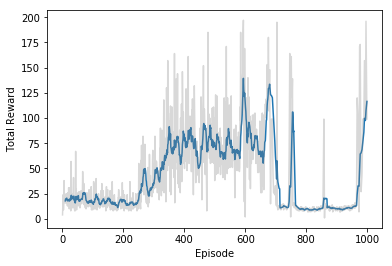

In [17]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [18]:
Text(0,0.5,'Total Reward')




NameError: name 'Text' is not defined

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.